# 1. Generate data

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import eig

import random

from scipy.sparse.csgraph import laplacian
from scipy.stats import bernoulli

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans 

import time


from simulate import *

In [2]:
n = 1000
m = 30
N = n + m
r = 2
p = 0.17
q = 0.11

In [3]:
# Generate group labels, group "2" is outlier
phi_ordered_o = [0] * int(n / 2) + [1] * int(n / 2) + [2] * int(m)
#phi_o = [i for i in random.sample(phi_ordered_o, n)]
phi_o = phi_ordered_o

In [4]:
# Generate connectivity matrix B
B_in = np.zeros((n, n))
for i in range(n):
    for j in range(i):
        if phi_o[i] == phi_o[j]:
            B_in[i, j] = .17
        else:
            B_in[i, j] = .11
B_in = B_in + B_in.transpose()

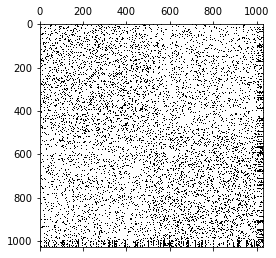

In [5]:
K = conn2adj(B_in)

# Generate adjacdncy matrix W for outliers
B_out = np.full((m, m), .7) - .7 * np.eye(m)

W = conn2adj(B_out)

# Generate Z
beta = np.random.uniform(low =  0, high= 1, size = n)
beta = beta ** 2
EZ = np.tile(beta, (m, 1)).transpose()

Z = np.zeros((n, m))
for idx, z in np.ndenumerate(EZ):
    #print(idx, z)
    Z[idx] = bernoulli.rvs(size = 1, p = z)
    
    
# Combine K, Z and W to be A
A_combined = np.concatenate((K, Z), axis = 1)
bottom = np.concatenate((Z.transpose(), W), axis = 1)
A_combined = np.concatenate((A_combined, bottom), axis = 0)


plt.matshow(A_combined, cmap = plt.cm.binary)

# 2. Algorithm 2

In [6]:
Z = 0
Lambda = 0
rho = 1
max_iter = 100
alpha = 0
lam = .19

In [7]:
E = alpha * np.eye(N) - (1 - lam) * A_combined + lam * (np.full((N, N), 1) - np.eye(N) - A_combined)

In [8]:
k = 0
time.start = time.time()
while k < max_iter:
    if k % 10 == 0:
        print("k = ", k, time.time() - time.start, "\n")
    # 1. Update Y ========
    
    X = Z - Lambda - E / rho
    X_values, V = eig(X)

    X_values_plus = X_values * (X_values > 0)
    Sigma_plus = np.zeros((N, N))
    np.fill_diagonal(Sigma_plus, X_values_plus)

    X_plus = V @ Sigma_plus @ V.transpose()
    Y = X_plus
    
    # 2. Update Z ========
    inside = (Y + Lambda) * (Y + Lambda > 0)
    Z = inside * (inside > 1) +  np.full((N, N), 1) * (inside <= 1)
    
    # 3. Update Lambda ========
    Lambda = Lambda + (Y - Z)
    
    k += 1

k =  0 0.00011324882507324219 

k =  10 38.85426211357117 

k =  20 74.50882816314697 

k =  30 110.57704305648804 

k =  40 146.57839512825012 

k =  50 183.05478811264038 

k =  60 218.90114402770996 

k =  70 255.84976625442505 

k =  80 291.93675804138184 

k =  90 327.2711091041565 



In [9]:
Xhat = Y
Xhat_normalized = normalize(Xhat, axis = 1, norm = 'l2')

In [10]:
yhat_list = []
mis_rates = []

mis_rates_inlier = []
for seed in range(100):
    kmeans = KMeans(n_clusters = 2, random_state = seed).fit(Xhat_normalized)
    yhat = kmeans.labels_
    yhat_list = yhat_list + [yhat]
    
    mis_rate = cal_mis_rate(phi_o, yhat)
    mis_rates = mis_rates + [mis_rate]
    
    mis_rate_inlier = cal_mis_rate(phi_o[:n], yhat[:n])
    mis_rates_inlier = mis_rates_inlier + [mis_rate_inlier]
    
    print("seed = ", seed, "mis rate inlier = ", mis_rate_inlier,
          ", mis rate = ", mis_rate, "\n")

seed =  0 mis rate inlier =  0.505 , mis rate =  0.5485436893203883 

seed =  1 mis rate inlier =  0.488 , mis rate =  0.5029126213592233 

seed =  2 mis rate inlier =  0.513 , mis rate =  0.5563106796116505 

seed =  3 mis rate inlier =  0.494 , mis rate =  0.5087378640776699 

seed =  4 mis rate inlier =  0.503 , mis rate =  0.5466019417475728 

seed =  5 mis rate inlier =  0.506 , mis rate =  0.5495145631067961 

seed =  6 mis rate inlier =  0.512 , mis rate =  0.5553398058252427 

seed =  7 mis rate inlier =  0.485 , mis rate =  0.5 

seed =  8 mis rate inlier =  0.484 , mis rate =  0.49902912621359224 

seed =  9 mis rate inlier =  0.496 , mis rate =  0.5106796116504855 

seed =  10 mis rate inlier =  0.489 , mis rate =  0.503883495145631 

seed =  11 mis rate inlier =  0.489 , mis rate =  0.503883495145631 

seed =  12 mis rate inlier =  0.506 , mis rate =  0.5495145631067961 

seed =  13 mis rate inlier =  0.511 , mis rate =  0.554368932038835 

seed =  14 mis rate inlier =  0.5